In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import datetime as dt
import yfinance as yf
import scipy.stats
import scipy as sp

plt.style.use("ggplot")

If there is a law in finance, that would be "level of price doesn't matter, only return matters" (I think it's from Paul Wilmott). It's weird the things (prices) we are modeling never show up in the equations.

# <font face="gotham" color="purple"> Simple vs Log Returns</font>

We have discussed the merits of log returns in time series session, it is time to revisit the topic before we dive into quantitative financial topics.

## <font face="gotham" color="purple"> Simple Multi-Period Return</font>

For compound return we have following formula
$$
S_T=S_0\left[1+\frac{r}{T}\right]^{Tt}
$$
where $S_0$ is initial investment,$t$ is the total duration (usually in years), $r$ is annual return, $T$ is number of compound periods (days, weeks, or seasons). If we break the compound period into infinitely small chunks, we receive continuous compound formula
$$
\lim _{T \rightarrow \infty} S_T=S_0 e^{rt}
$$

Sometimes we just omitted $t$ if we are modeling one year duration.

And this plot shows that as the number of compound periods increase, discrete compounding converges to continous 

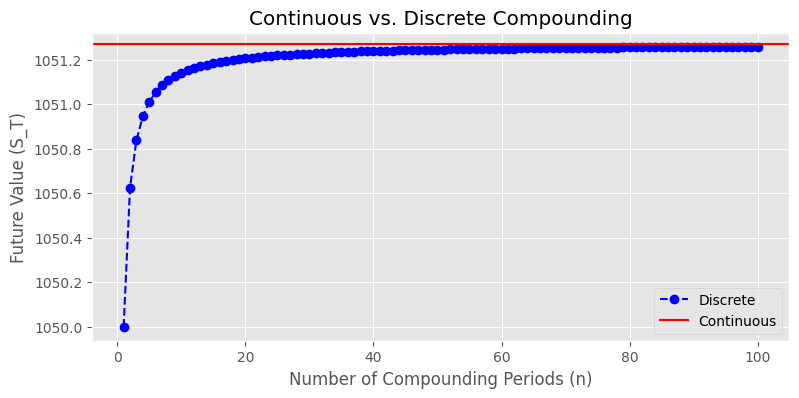

In [27]:
S_0 = 1000
r = 0.05
t = 1 

S_T_continuous = S_0 * np.exp(r * t)

compound_periods = range(1, 101)  
S_T_discrete = [S_0 * (1 + r / n) ** (n * t) for n in compound_periods]

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(compound_periods, S_T_discrete, label="Discrete", linestyle='--', marker='o', color='blue')
ax.axhline(y=S_T_continuous, color='r', linestyle='-', label="Continuous")
ax.set_xlabel("Number of Compounding Periods (n)")
ax.set_ylabel("Future Value (S_T)")
ax.legend()
plt.title("Continuous vs. Discrete Compounding")
plt.show()


## <font face="gotham" color="purple"> Simple Returns Simulation</font>

In [4]:
s0 = 100
r = 0.1
sigma = 0.10

trading_days = 252
paths = 1000
norm_draws = [np.random.randn(trading_days) for i in range(paths)]

Add a random component into simple return, the $\sqrt{T}$ comes from the properties of variance $\sqrt{\operatorname{Var}(T \varepsilon)} = \sqrt{T} * \sigma(\varepsilon)$

$\begin{aligned} r_t= & \frac{S_t-S_{t-1}}{S_{t-1}} \\ & =\frac{r}{T}+\frac{\sigma}{\sqrt{T}} \varepsilon_t \quad \varepsilon_t \sim N(0,1)\end{aligned}$

In [5]:
daily_simp_rets = [
    1 + r / trading_days + sigma / (np.sqrt(trading_days)) * i for i in norm_draws
]
# insert 1 at the begining for every normal random sequence
# this is for accumulative calculation
daily_simp_rets_gross = [np.insert(i, 0, 1) for i in daily_simp_rets]
# simple return is multiplicative
simple_rets = [np.cumprod(x) for x in daily_simp_rets]

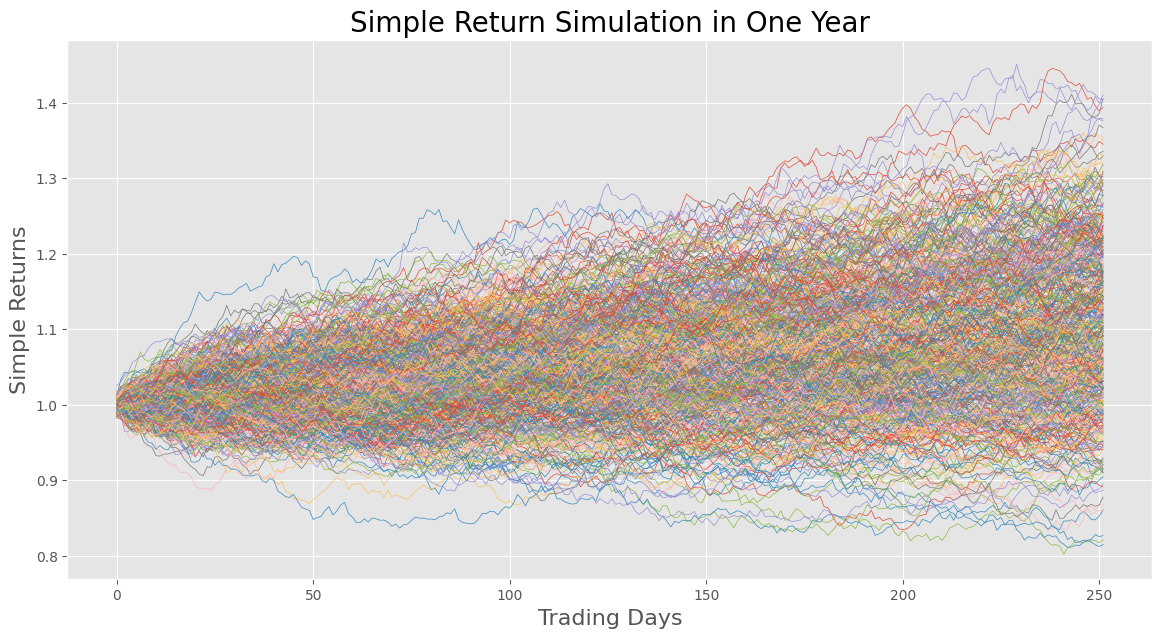

In [6]:
fig, ax = plt.subplots(figsize=(14, 7))

for p in simple_rets[:500]:
    ax.plot([z for z in range(0, trading_days)], p, linewidth=0.5)

ax.set_title("Simple Return Simulation in One Year", fontsize=20)
ax.set_xlabel("Trading Days", fontsize=16)
ax.set_ylabel("Simple Returns", fontsize=16)
plt.show()

The simulation shows positive skewed feature simply because we set a positive $r$ such as $r=.1$.

An unfavorable feature of simple return is
$$
\left(1+r_1\right)\left(1+r_2\right) \ldots \left(1+r_T\right)-1=\prod_{i=0}^T\left(1+r_i\right)-1
$$
the product of simple return does not follow a normal distribution.

## <font face="gotham" color="purple"> Log Return</font>

Continuous compound has an additive feature on exponential term, we can show
$$
\begin{aligned} S_T & =S_0e^{\frac{r}{T}}e^{\frac{r}{T}} \ldots e^{\frac{r}{T}} \\ & =S_0 e^{\frac{r}{T}+\ldots+\frac{r}{T}} \\ & =S_0 e^r\end{aligned}
$$

Divide $S_0$ on both side and take natural log, we obtain log return at period $T$
$$
\log{\left(\frac{S_T}{S_0}\right)}=\log{e^r} = r_{_T}[T]
$$
The notation is consistent with what we had in time series session, $r_{_T}[T]$ means $T$ periods log return.

What's more, we can decompose gross return into additive log returns
$$
\begin{align}
\log{\left(\frac{S_T}{S_{T-1}}\frac{S_{T-1}}{S_{T-2}}\ldots\frac{S_1}{S_0}\right)} &= \log{\left(\frac{S_T}{S_{T-1}}\right)}
\log{\left(\frac{S_T}{S_{T-1}}\right)}
\ldots\log{\left(\frac{S_T}{S_{T-1}}\right)}\\
r_{_T}[T]&= \underbrace{r_{_{T-1}} + r_{_{T-2}}+\ldots+r_{_0}}_{T \text{ periods}}
\end{align}
$$
which means the log return has additive features.

Note that $r_{_T}[T]\neq r_{_T}$, the former one is an accumulative return the later is a single period return.

In contrast to simple returns, $r_{_T}[T]$ still follows a normal distribution, because it's a linear combination of $T$ normal distributions.

### <font face="gotham" color="purple"> Simulation of Log Return</font>

Similarly, we add random components on to log return

$$
\ln \left(\frac{S_T}{S_0}\right)=r+\sigma \varepsilon_t, \quad \varepsilon_t \sim N(0,1)
$$

# <font face="gotham" color="purple"> So Which One to Use?</font>

For individual investor without serious quantitative intention, it probably doesn't matter that much which one you use, but for institutions with rigorous quantitative research, this will be among first topics to address before any financial modeling.

The merit of simple return: simple returns are **asset-additive**.

The portfolio return can be added up together
$$
R_p=\sum_{i=1}^k w_i R_i
$$
where $R_p$ is portfolio return, $w_i$ and $R_i$ are weight and simple return of asset $i$.

In contrast, log returns are **time-additive**, i.e.
$$
r_{_T}[T]= r_{_{T-1}} + r_{_{T-2}}+\ldots+r_{_0}
$$

In fact, log returns are not a linear function of asset weights. That is, a portfolio's log return does not equal the weighted average of the log returns of the assets in the portfolio.

The log return of portfolio $r_p$ mathematically will be
$$
r_p=\log \left(\sum_{i=1}^N w_i e^{r_i}\right)
$$
where $w_i$ and $r_i$ are weight and log return of asset $i$. Obviously this is no longer a linear function.

## <font face="gotham" color="purple"> Comparison Experiment</font>

We download two ETFs' (SPY and AGG) historical data and using weight $[0.6, 0.4]$ to calculate the portfolio return.

We calculate the log return of each assets, but using additive method for calculating the portfolio return. Use this return to compare with correct simple portfolio, we expect to see a discrepancy between them.

In [7]:
def downloadData(stocks, dropna=True):
    # dropna decides if you want to drop all NaN values
    stock_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)["Close"]
    if dropna == True:
        df = pd.DataFrame(stock_data).dropna()
    else:
        df = pd.DataFrame(stock_data)
    return df

In [8]:
stocks = ["SPY", "AGG"]
start_date = "2015-01-01"
end_date = dt.datetime.today()

data = downloadData(stocks)

In [9]:
data_simple_return = data.pct_change().dropna()
data_log_return = np.log(data) - np.log(data.shift())

trading_days = 252
weights = np.array([0.6, 0.4])
simple_portfolio_return = np.sum(data_simple_return.mean() * weights) * trading_days
mixed_portfolio_return = np.sum(data_log_return.mean() * weights) * trading_days

print("Simple portfolio return: {:.4f}".format(simple_portfolio_return))
print(
    "Simple portfolio return with log asset return: {:.4f}".format(
        mixed_portfolio_return
    )
)

Simple portfolio return: 0.0887
Simple portfolio return with log asset return: 0.0786


So you have to be consistent about when to use which. In general for time series modeling, log return is your choice, when comes to portfolio optimization, simple return would be more accurate.

## <font face="gotham" color="purple"> Standardized Return vs Normal Distribution </font>

Standardized return is useful when we are curious about how frequently the return would drop onto some rare cases. 

For instance, AGG has some rare cases that a single day return had $12$ standard deviation down from the last close price.

In [10]:
def standardizedReturn(simple_return):
    return (simple_return - simple_return.mean()) / np.std(simple_return)

In [11]:
n = 300
norm_pdf = sp.stats.norm.pdf(np.linspace(-10, 10, n), loc=0, scale=1)
x_ticks = np.linspace(-10, 10, n)

Compare with standard normal distribution.

c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\weijie-chen-Vyy5-xRM-py3.12\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


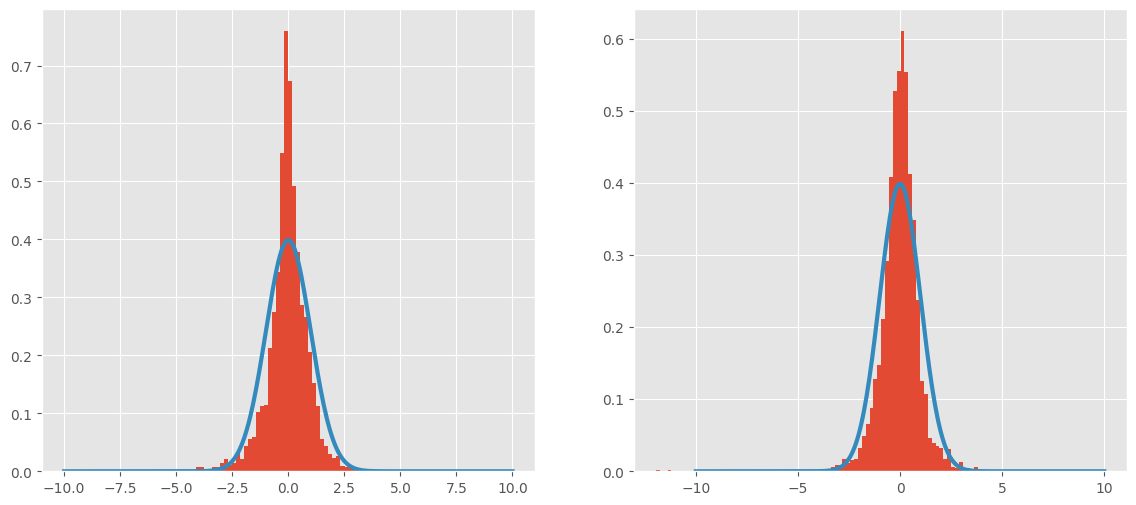

In [12]:
fig, ax = plt.subplots(figsize=(14, 6), nrows=1, ncols=2)
ax[0].hist(
    standardizedReturn(data_simple_return)["SPY"], bins=100, density=True, label="SPY"
)
ax[1].hist(
    standardizedReturn(data_simple_return)["AGG"], bins=100, density=True, label="AGG"
)
ax[0].plot(x_ticks, norm_pdf, lw=3, label="Normal")
ax[1].plot(x_ticks, norm_pdf, lw=3, label="Normal")
plt.show()

The return distribution is not Gaussian, but _why we insist using normal distribution in practice_. There are number of reason: normal distribution has a closed form function, only two parameters, central limited theorem guarantees its generalization and finite standard deviation. 

On the contrary, the fat tailed distribution as the histograms show, it might not have closed form pdf function, and of most importance standard deviation could be infinitely large.

So if you insist using fat tail model, sometimes not possible to model anything due to infinite standard deviation.

However, though fat tails has extremely low probability, we still need to have strategy handling it.

## <font face="gotham" color="purple"> Assets Return Modeling </font>

We have seen discrete simple compound return previously
$$
S_T=S_0\left[1+\frac{r}{T}\right]^{Tt},\qquad\lim _{T \rightarrow \infty} S_T=S_0 e^{rt}
$$
This notation is commonly used in time series analysis.

In financial engineering, we commonly express it as
$$
S_M = S_0(1+\mu \delta t)^M, \qquad\lim _{\delta t \rightarrow 0} S_M=S_0 e^{\mu M \delta t} = S_0 e^{\mu t}
$$
where $M=\frac{t}{\delta t}$, $\mu$ is annual return. For instance, if we are modeling daily data in US, $\delta t = 252$.

Now suppose you know annualized standard deviation of return $\sigma$, the variance over $M$ periods (can be days, months or years) will be
$$
\sum_{i=1}^{M}\sigma^2 = M \sigma^2 = \frac{t}{\delta t}\sigma^2
$$

If we set $t=1$, i.e. one year period (252 trading days), we obtain variance over $1/\delta t$ periods
$$
\frac{1}{\delta t}\sigma^2
$$

**[Something wrong here, I derived a wrong result]**

Naturally, the standard deviation over $1/\sqrt{\delta t}$ periods will be 
$$
\frac{1}{\sqrt{\delta t}} \sigma
$$

So if you know annualized $\sigma = .15$, what's the standard deviation over a day?
$$
\frac{\sigma}{\sqrt{252}} = \frac{0.15}{\sqrt{252}}
$$

In contrast, the time unit conversion of mean is straightforward, the mean over certain period of time
$$
\mu \ \delta t
$$
where $\mu$ is annualized return, e.g. $\mu=0.08$, daily return is
$$
0.08 \times \frac{1}{252}
$$

Now join what we have discussed together, we can write a model for returns
$$
R_{t} = \frac{S_{t+1}-S_t}{S_t} =  \mu \delta t+\varepsilon \sigma \sqrt{\delta t}
$$
where $\varepsilon$ is a variable drawn from normal distribution (doesn't have to be standard normal).

Actually this is a famous stochastic process model named **generalized Wiener Process**.

In [13]:
spy = data["SPY"]
spy = spy.pct_change()
mean_spy = spy.mean()
std_spy = spy.std()

In [14]:
trading_days = 252
paths = 1000
init_capital = 1000
norm_draws = [np.random.randn(trading_days) for i in range(paths)]

We don't write it exactly as in our model, because the model is for daily return, we already have daily return computed in variables ```mean_spay``` and ```std_spy```, so we simply use $1+\mu_d+\phi\sigma$ for gross return.

In [15]:
daily_simp_rets = [1 + mean_spy + std_spy * epsilon for epsilon in norm_draws]

In [16]:
daily_simp_rets_gross = [np.insert(i, 0, 1) for i in daily_simp_rets]
simple_rets = [np.cumprod(x) for x in daily_simp_rets]
simple_rets_init_cap = list(
    map(lambda x: 1000 * x, [np.cumprod(x) for x in daily_simp_rets])
)

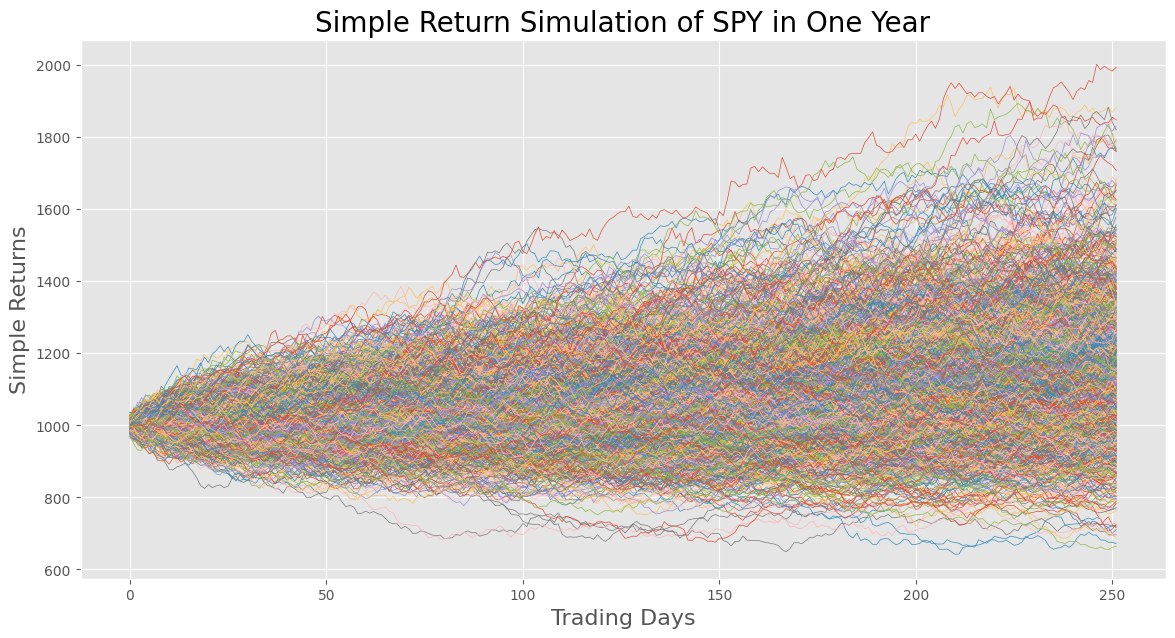

In [17]:
fig, ax = plt.subplots(figsize=(14, 7))

for j in simple_rets_init_cap:
    ax.plot([i for i in range(0, trading_days)], j, linewidth=0.5)

ax.set_title("Simple Return Simulation of SPY in One Year", fontsize=20)
ax.set_xlabel("Trading Days", fontsize=16)
ax.set_ylabel("Simple Returns", fontsize=16)
plt.show()

## <font face="gotham" color="purple"> Assets Price Level Modeling </font>

With a slight modification of previous model
$$
S_{i+1}-S_i=\mu S_i \delta t+\varepsilon   S_i \sigma\sqrt{\delta t}\quad\Rightarrow\quad S_{i+1}=(1+\mu \delta t) S_i+\varepsilon  S_i \sigma\sqrt{\delta t}
$$

It provides a more practical usage, that is to simulate asset price in the next period.

In [18]:
# use lastest close price
today_price = data["SPY"][-1]
trading_days = 1
paths = 10000
norm_draws = [np.random.randn(trading_days) for i in range(paths)]
next_day_price = [
    (1 + mean_spy) * today_price + epsilon * today_price * std_spy
    for epsilon in norm_draws
]
next_day_price = [np.insert(i, 0, data["SPY"][-1]) for i in next_day_price]

C:\Users\user\AppData\Local\Temp\ipykernel_22636\1175934686.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  today_price = data["SPY"][-1]
C:\Users\user\AppData\Local\Temp\ipykernel_22636\1175934686.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  next_day_price = [np.insert(i, 0, data["SPY"][-1]) for i in next_day_price]


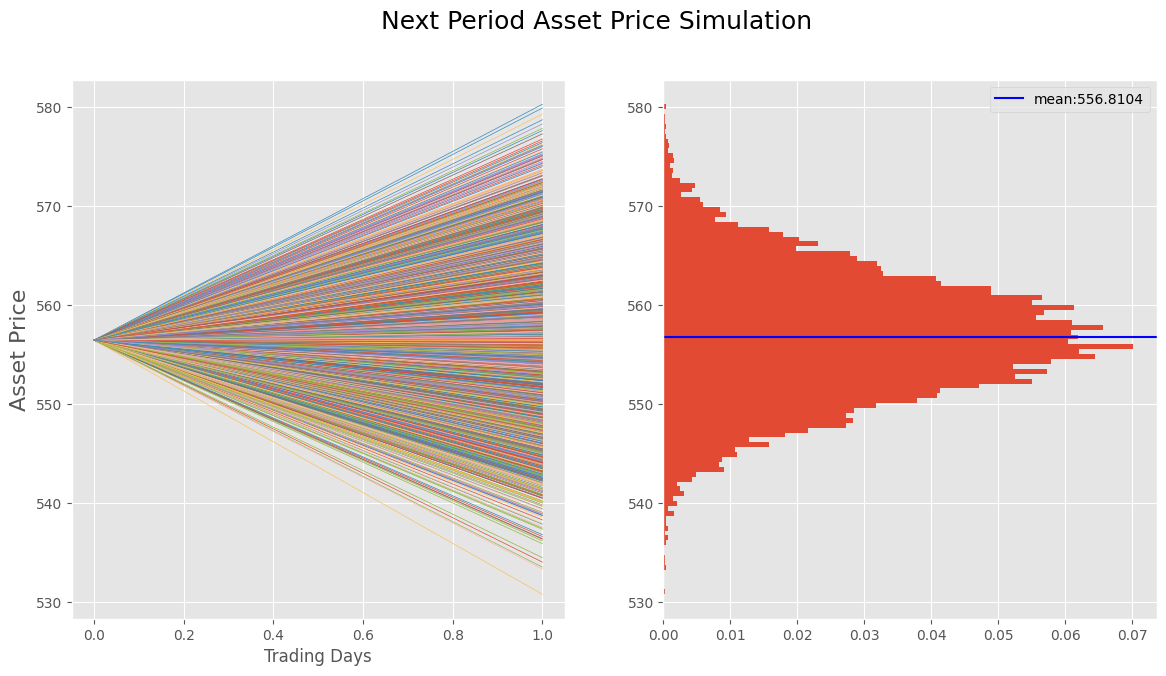

In [19]:
fig, ax = plt.subplots(figsize=(14, 7), nrows=1, ncols=2)

for j in next_day_price:
    ax[0].plot([i for i in range(0, trading_days + 1)], j, linewidth=0.5)

ax[0].set_ylabel("Asset Price", fontsize=16)
ax[0].set_xlabel("Trading Days")

next_price_list = []
for i in next_day_price:
    next_price_list.append(i[1])

ax[1].hist(next_price_list, bins=100, orientation="horizontal", density=True)
ax[1].axhline(
    np.mean(next_price_list),
    color="blue",
    label="mean:{:.4f}".format(np.mean(next_price_list)),
)
ax[1].legend()
plt.suptitle("Next Period Asset Price Simulation", size=18)
plt.show()

## <font face="gotham" color="purple"> Insights </font>

Take a close look at the model
$$
S_{i+1}-S_i=\mu S_i \delta t+\varepsilon   S_i \sigma\sqrt{\delta t}
$$

On the left-hand side, $\delta t$ appears twice, i.e. $\delta t$ and $\sqrt{\delta t}$. 

From this plot, we know that if $0<\delta t < 1$, then $\delta t<\sqrt{\delta t}$. When $\delta t$ approaches $0$, the $\varepsilon   S_i \sigma\sqrt{\delta t}$ term will be very dominant, that means we will be modeling volatility predominantly in extremely short time duration.

In other words, in the short term random noise is much bigger than the growth (drift).

In [20]:
x, y = np.linspace(0, 1.3), np.sqrt(x)
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(1, 1, color="red", s=100)
ax.plot(x, y, label="$y = \sqrt{\delta t}$")
ax.plot(x, x, label="$y = \delta t$")
ax.legend()
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\user\AppData\Local\Temp\ipykernel_22636\519204168.py:4: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(x, y, label="$y = \sqrt{\delta t}$")
C:\Users\user\AppData\Local\Temp\ipykernel_22636\519204168.py:5: SyntaxWarning: invalid escape sequence '\d'
  ax.plot(x, x, label="$y = \delta t$")
C:\Users\user\AppData\Local\Temp\ipykernel_22636\519204168.py:4: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(x, y, label="$y = \sqrt{\delta t}$")
C:\Users\user\AppData\Local\Temp\ipykernel_22636\519204168.py:5: SyntaxWarning: invalid escape sequence '\d'
  ax.plot(x, x, label="$y = \delta t$")


NameError: name 'x' is not defined

For the sake of mathematical convenience, many people will be using _continuous version_ of this model, i.e.
$$
d S=\mu S d t+\sigma S d X
$$
where $E[d X]=0$ and $E\left[d X^2\right]=d t$. A full derivation will be carefully discussed in later chapters, because this is the foundation of all other quantitative financial models.

Financial engineering in three subfields
1. Pricing
2. Risk management
3. Trading strategies

We can do an experiment, if we first calculate the log return of each asset, then use additive method to calculate the portfolio return, would it be the same as the simple return?